In [151]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone

In [152]:
start_day_to_analyze = '2020-03-27'
end_day_to_analyze = '2020-03-28'

In [153]:
base_url = "https://api.alpaca.markets"
api_key_id = "PKO3OSD9LU9GTQPL69GO"
api_secret = "chnPFlGXbY4Y4QAAZ3Q7MJHxkxBYB30CQZNVZTaj"

In [154]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [155]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [156]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [157]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [158]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [159]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [160]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,121,algo.py,PAPER,v0.1-153-g4a30d48,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-03-27 13:45:20.419822,2020-03-27 20:10:00.622999,market close


,symbol,count,revenue
11,CTK,2,-112.21
8,SPXS,2,-60.50
14,TECS,2,-51.68
2,SPWH,5,-46.27
9,FNGD,2,-45.79
12,APVO,2,-43.40
7,SDC,3,-28.70
16,LABD,2,-27.37
6,TLRY,3,-14.64
13,SPKE,2,-9.36


TOTAL REVENUE: -254.93 $


In [161]:

minute_history = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=7)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df

In [162]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.01 <= float(item - prev) / prev <= 0.01:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    minute_history_index = minute_history["high"].index.get_loc(now, method='nearest')
    series = minute_history["high"][minute_history_index-200:minute_history_index].dropna().resample("5min").min()
    print(f'current_value={current_value} series = {series.values}')
    diff = np.diff(series.values)
    high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
    if len(high_index) > 0:
        local_maximas = sorted([series[i] for i in high_index if series[i] > current_value])
        print(local_maximas)
        clusters = dict(enumerate(grouper(local_maximas), 1))
        print(clusters)
        resistances = []
        for key, cluster in clusters.items():
            if len(cluster) > 1:
                resistances.append(round(sum(cluster) / len(cluster), 2))
        resistances = sorted(resistances)
        print (f'resistances={resistances}')
        return resistances

    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    minute_history_index = minute_history["high"].index.get_loc(now, method='nearest')
    series = minute_history["high"][minute_history_index-200:minute_history_index].dropna().resample("5min").min()
    print(f'current_value={current_value} series = {series.values}')
    diff = np.diff(series.values)
    high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
    if len(high_index) > 0:
        local_maximas = sorted([series[i] for i in high_index if series[i] <= current_value])
        print(local_maximas)
        clusters = dict(enumerate(grouper(local_maximas), 1))
        print(clusters)
        supports = []
        for key, cluster in clusters.items():
            if len(cluster) > 1:
                supports.append(round(sum(cluster) / len(cluster), 2))
        supports = sorted(supports)
        print (f'supports={supports}')
        return supports
    
    return None

current_value=2.14 series = [2.31   2.3    2.2772 2.33   2.32   2.35   2.35   2.34   2.3401 2.34
 2.291  2.28   2.275  2.31   2.31   2.31   2.29   2.275  2.2601    nan
 2.26   2.26   2.25   2.23   2.2    2.215  2.27   2.22   2.2149 2.1543
 2.16   2.23   2.16   2.16   2.15   2.15   2.15   2.15   2.1241 2.11
 2.12   2.13   2.13   2.13   2.085  2.09   2.0701 2.04   2.035  2.035
 2.03   2.035  2.0275 2.025  1.99   1.9925 1.98   1.96   1.95   1.93
 1.915  1.93   1.95   1.9   ]
[2.15, 2.15, 2.15, 2.16, 2.23, 2.26, 2.27, 2.31, 2.31, 2.31, 2.33, 2.3401, 2.35, 2.35]
{1: [2.15, 2.15, 2.15, 2.16], 2: [2.23], 3: [2.26, 2.27], 4: [2.31, 2.31, 2.31, 2.33, 2.3401, 2.35, 2.35]}
resistances=[2.15, 2.26, 2.33]
current_value=2.14 series = [2.31   2.3    2.2772 2.33   2.32   2.35   2.35   2.34   2.3401 2.34
 2.291  2.28   2.275  2.31   2.31   2.31   2.29   2.275  2.2601    nan
 2.26   2.26   2.25   2.23   2.2    2.215  2.27   2.22   2.2149 2.1543
 2.16   2.23   2.16   2.16   2.15   2.15   2.15   2.15   2.

<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1016.50,-1016.50,buy,2020-03-27 13:56:15.495848,2.14,"[2.04, 2.13]","[2.15, 2.26, 2.33]",475,"{'rsi': 71.48910392158496, 'macd': [0.027657845585995045, 0.027538671020734373, 0.03032235281694673, 0.03454293140011089, 0.03746397808036628], 'sell_macd': [0.017427233653333207, 0.017234461507944054, 0.018938347349096052, 0.021573344792213067, 0.0233516110492884], 'slow macd': [-8.906245531470347e-05, 0.0009188769072712155, 0.002484487849166772, 0.00439913512062029, 0.006155235412955928], 'macd_signal': [0.022931449231994222, 0.02385289358974225, 0.025146785435183148, 0.027026014628168695, 0.029113607318608212], 'sell_macd_signal': [0.01480895242943899, 0.015294054245140003, 0.016022912865931212, 0.017132999251187584, 0.018376721610807747]}",2.65,1.97
1,-653.10,363.40,sell,2020-03-27 14:03:21.319939,2.30,None,None,158,"{'rsi': 79.07799140252332, 'macd': [0.026022199016381364, 0.027189074894895082, 0.02878418499640034, 0.03121174890671119, 0.03685385391595686], 'reasons': 'scale-out AND rsi max', 'movement': 0.0269518812502802, 'macd_signal': [0.020237453455558864, 0.021627777743426106, 0.023059059194020952, 0.024689597136559, 0.027122448492438573]}",2.65,1.97
2,76.00,729.10,sell,2020-03-27 14:03:25.876571,2.30,None,None,317,"{'rsi': 79.69534057607716, 'macd': [0.027189074894895082, 0.02878418499640034, 0.03121174890671119, 0.03685385391595686, 0.041291158417759544], 'reasons': 'rsi max', 'movement': 0.004366812227074143, 'macd_signal': [0.021627777743426106, 0.023059059194020952, 0.024689597136559, 0.027122448492438573, 0.029956190477502767]}",2.65,1.97
3,-213.38,-289.38,buy,2020-03-27 14:12:36.711972,2.73,"[2.04, 2.14, 2.26, 2.33]",[],106,"{'rsi': 72.94995039028622, 'macd': [0.09359721583905145, 0.13281619854232352, 0.14049128529226795, 0.15567272037792534, 0.16938270262021637], 'sell_macd': [0.058737764523368874, 0.08396976188204963, 0.08851456811112479, 0.09791942272974019, 0.10631386239710627], 'slow macd': [0.028303401639147463, 0.03883179633155187, 0.0441378774998431, 0.05110818587978638, 0.05815906426392514], 'macd_signal': [0.058869494594942604, 0.07365883538441878, 0.08702532536598862, 0.10075480436837596, 0.11448038401874404], 'sell_macd_signal': [0.03679302476719543, 0.046228372190166275, 0.05468561137435798, 0.06333237364543443, 0.07192867139576879]}",5.01,1.97
4,-113.98,99.40,sell,2020-03-27 14:12:56.266316,2.84,None,None,35,"{'rsi': 74.88855192416834, 'macd': [0.058737764523368874, 0.08396976188204963, 0.08851456811112479, 0.09791942272974019, 0.11046970655295052], 'reasons': 'scale-out', 'movement': 0.029304029304029332, 'macd_signal': [0.03679302476719543, 0.046228372190166275, 0.05468561137435798, 0.06333237364543443, 0.07275984022693764]}",5.01,1.97
5,-48.20,65.78,sell,2020-03-27 14:13:15.606845,2.86,None,None,23,"{'rsi': 76.18969567541015, 'macd': [0.08396976188204963, 0.08851456811112479, 0.09791942272974019, 0.11254762863087242, 0.1234975601300552], 'reasons': 'scale-out', 'movement': 0.021174377224199247, 'macd_signal': [0.046228372190166275, 0.05468561137435798, 0.06333237364543443, 0.07317542464252202, 0.08323985174002865]}",5.01,1.97
6,-0.84,47.36,sell,2020-03-27 14:14:32.130404,2.96,None,None,16,"{'rsi': 75.85706286438753, 'macd': [0.08851456811112479, 0.09791942272974019, 0.11254762863087242, 0.11988717051966535, 0.1318415256210672], 'reasons': 'scale-out', 'movement': 0.02805366788639144, 'macd_signal': [0.05468561137435798, 0.06333237364543443, 0.07317542464252202, 0.0825177738179507, 0.092382524178574]}",5.01,1.97
7,31.36,32.20,sell,2020-03-27 14:25:03.098549,3.22,None,None,10,"{'rsi': 70.73247137049837, 'macd': [0.11471019791353188, 0.11001661613946911, 0.10598503792410208, 0.10637621025077593, 0.11699821193064164], 'reasons': 'scale-out', 'movement': 0.029126213592233108, 'macd_signal': [0.11992493958170179, 0.11794327489325526, 0.11555162749942463, 0.11371654404969489, 0.11437287762588425]}",5.01,1.97
8,54.8

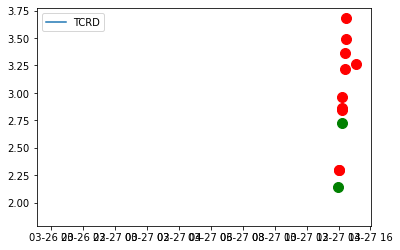

current_value=7.78 series = [7.09   7.07   7.088  7.09   7.09   7.1    7.105  7.1388 7.16   7.16
 7.14   7.11   7.1    7.06   7.08   7.08   7.04   7.05   7.06   7.1
 7.14   7.08   7.06   7.08   7.0798 7.11   7.1    7.09   7.1099 7.11
 7.14   7.14   7.12   7.12   7.1198 7.12   7.1    7.1    7.11   7.1
 7.11   7.1101    nan 7.11   7.14   7.11      nan 7.15      nan    nan
 7.15      nan 7.15   7.15   7.11   7.15   7.11      nan 7.14   7.1
 7.09   7.09   7.1    7.15   7.17   7.17   7.17   7.18   7.24  ]
[]
{}
resistances=[]
current_value=7.78 series = [7.09   7.07   7.088  7.09   7.09   7.1    7.105  7.1388 7.16   7.16
 7.14   7.11   7.1    7.06   7.08   7.08   7.04   7.05   7.06   7.1
 7.14   7.08   7.06   7.08   7.0798 7.11   7.1    7.09   7.1099 7.11
 7.14   7.14   7.12   7.12   7.1198 7.12   7.1    7.1    7.11   7.1
 7.11   7.1101    nan 7.11   7.14   7.11      nan 7.15      nan    nan
 7.15      nan 7.15   7.15   7.11   7.15   7.11      nan 7.14   7.1
 7.09   7.09   7.1    7.15   7.1

<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1081.42,-1081.42,buy,2020-03-27 13:47:07.281877,7.78,[7.13],[],139,"{'rsi': 74.87605453680362, 'macd': [0.1273933517931587, 0.128923355999083, 0.13024830680430455, 0.136989526873303, 0.1422974397265273], 'sell_macd': [0.07814098580707896, 0.07873978129428405, 0.07922274165711496, 0.08325072711312487, 0.08634200503841694], 'slow macd': [0.0576652028856639, 0.06119649521211201, 0.06466739391755372, 0.06919832888178767, 0.07357453361476463], 'macd_signal': [0.1182528597384277, 0.12038695899055876, 0.12235922855330791, 0.12528528821730694, 0.128687718519151], 'sell_macd_signal': [0.0738872699781828, 0.07485777224140305, 0.07573076612454543, 0.07723475832226132, 0.07905620766549244]}",9.52,7.20
1,13.90,1095.32,sell,2020-03-27 13:48:14.678720,7.88,None,None,139,"{'rsi': 78.53346398063535, 'macd': [0.07873978129428405, 0.07922274165711496, 0.08325072711312487, 0.08997836867477993, 0.09561057809068352], 'reasons': 'rsi max', 'movement': 0.012853470437017948, 'macd_signal': [0.07485777224140305, 0.07573076612454543, 0.07723475832226132, 0.07978348039276503, 0.08294889993234873]}",9.52,7.20
2,-703.44,-717.34,buy,2020-03-27 13:52:08.464979,8.06,[7.13],[],89,"{'rsi': 73.5548120613633, 'macd': [0.16549904265816906, 0.19696010277200582, 0.21856680112020221, 0.22183624511243405, 0.22346516852386955], 'sell_macd': [0.10106512354522845, 0.12111889196966619, 0.13465275188520653, 0.13617715244426076, 0.13663542362736436], 'slow macd': [0.08179003154022713, 0.09210614950750173, 0.10129006108073924, 0.10733844983951446, 0.1130513601692158], 'macd_signal': [0.1369434306404018, 0.1489467650667226, 0.16287077227741853, 0.17466386684442164, 0.18442412718031123], 'sell_macd_signal': [0.08403980902325772, 0.09145562561253942, 0.10009505086707285, 0.10731147118251043, 0.11317626167148122]}",10.80,7.20
3,-16.36,687.08,sell,2020-03-27 14:18:10.236364,7.72,None,None,89,"{'rsi': 38.90469227710113, 'macd': [0.021805368893353716, 0.02007732345962765, 0.01639732281698958, 0.00915579864328464, -0.001800659136788063], 'reasons': 'below cost & macd negative', 'movement': -0.04567901234567892, 'macd_signal': [0.03269188923273063, 0.030168976078110032, 0.027414645425885942, 0.023762876069365682, 0.018650169028134933]}",10.80,7.20
4,-2378.46,-2362.10,buy,2020-03-27 14:53:16.800373,7.90,[7.13],[],299,"{'rsi': 63.43674449447085, 'macd': [-0.02736343792485041, -0.01941953745072489, -0.012974378532812025, -0.005750685608147066, 0.0051277140975942714], 'sell_macd': [-0.017329848778673274, -0.01203563938529495, -0.007753974411424558, -0.0029974306082607427, 0.004103738986519723], 'slow macd': [0.0288235664845109, 0.0285682183001974, 0.028287598929823687, 0.028390415576385664, 0.029472790403027638], 'macd_signal': [-0.021929313050952408, -0.021427357930906905, -0.01973676205128793, -0.016939546762659758, -0.012526094590608952], 'sell_macd_signal': [-0.014315980003160006, -0.013859911879586994, -0.012638724385954507, -0.010710465630415753, -0.007747624707028658]}",8.74,7.66
5,-1558.74,819.72,sell,2020-03-27 15:34:11.535425,8.28,None,None,99,"{'rsi': 70.89286205970818, 'macd': [0.0281434842006707, 0.030536024628299074, 0.03262714671959088, 0.03528740878138237, 0.04001894533886308], 'reasons': 'scale-out', 'movement': 0.020987654320987648, 'macd_signal': [0.02688293155688457, 0.02761355017116747, 0.028616269480852153, 0.029950497340958195, 0.03196418694053917]}",8.74,7.66
6,43.26,1602.00,sell,2020-03-27 15:44:55.171882,8.01,None,None,200,"{'rsi': 38.390015517563235, 'macd': [0.03183686552319642, 0.02671525209739478, 0.016663147452646854, 0.009133414645667415, -0.0004888890304943772], 'reasons': 'below cost & macd negative', 'movement': -0.036275695284159595, 'macd_signal': [0.03810230653692894, 0.03582489564902211, 0.03199254600974706, 0.02742071973693113, 0.02183879798344603]}",8.74,7.66


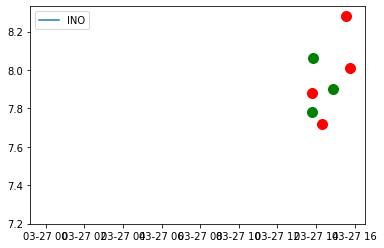

current_value=5.97 series = [5.72  5.73  5.73  5.71  5.72  5.7   5.68  5.65  5.64  5.66  5.69  5.71
 5.74  5.74  5.735 5.71  5.72  5.67  5.67  5.65  5.65  5.61  5.6   5.59
 5.62  5.6   5.57  5.575 5.558 5.55  5.57  5.6   5.58  5.575 5.56  5.58
 5.595 5.61  5.89  6.    5.9     nan 5.9     nan 6.    6.37  6.28  6.27
 6.5   6.55  6.65    nan   nan   nan 6.55 ]
[6.0, 6.37]
{1: [6.0], 2: [6.37]}
resistances=[]
current_value=5.97 series = [5.72  5.73  5.73  5.71  5.72  5.7   5.68  5.65  5.64  5.66  5.69  5.71
 5.74  5.74  5.735 5.71  5.72  5.67  5.67  5.65  5.65  5.61  5.6   5.59
 5.62  5.6   5.57  5.575 5.558 5.55  5.57  5.6   5.58  5.575 5.56  5.58
 5.595 5.61  5.89  6.    5.9     nan 5.9     nan 6.    6.37  6.28  6.27
 6.5   6.55  6.65    nan   nan   nan 6.55 ]
[5.575, 5.6, 5.62, 5.65, 5.67, 5.72, 5.72, 5.73, 5.73, 5.74, 5.74]
{1: [5.575, 5.6, 5.62, 5.65, 5.67, 5.72, 5.72, 5.73, 5.73, 5.74, 5.74]}
supports=[5.68]
current_value=6.06 series = [5.72  5.73  5.73  5.71  5.72  5.7   5.68  5.65 

<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1605.93,-1605.93,buy,2020-03-27 13:48:56.610911,5.97,[5.68],[],269,"{'rsi': 53.197963546405994, 'macd': [0.07309768846545328, 0.07536302092182989, 0.08066648058512449, 0.08430119706679307, 0.08977795559725354], 'sell_macd': [0.04594425511637734, 0.04715822779923595, 0.05034887887939554, 0.05244095921615077, 0.05572776260562051], 'slow macd': [0.022715963387619276, 0.025233747661841832, 0.028389480018633506, 0.03132741773670844, 0.03470002270205974], 'macd_signal': [0.05158427466817318, 0.056340023918904525, 0.06120531525214852, 0.06582449161507743, 0.07061518441151265], 'sell_macd_signal': [0.032630408947237004, 0.035535972717636796, 0.038498553949988544, 0.04128703500322099, 0.0441751805237009]}",6.89,5.69
1,-1059.47,546.46,sell,2020-03-27 13:55:32.142267,6.14,None,None,89,"{'rsi': 60.77420706090053, 'macd': [0.06034494898894227, 0.058829430607498345, 0.05636500809458678, 0.05791006836901236, 0.062216478084550886], 'reasons': 'scale-out', 'movement': 0.0242070116861435, 'macd_signal': [0.05187776975210488, 0.053268101923183576, 0.053887483157464215, 0.05469200019977384, 0.05619689577672925]}",6.89,5.69
2,-2.87,1056.60,sell,2020-03-27 14:16:08.139590,5.87,None,None,180,"{'rsi': 41.803014134710125, 'macd': [0.006377267307169809, 0.006828480334818643, 0.004753731001366113, 0.0025558259233333658, -0.0012679420066055158], 'reasons': 'below cost & macd negative', 'movement': -0.044824775876120534, 'macd_signal': [0.010749710956016975, 0.009965464831777309, 0.00892311806569507, 0.007649659637222729, 0.0058661393084570804]}",6.89,5.69
3,-1881.47,-1878.60,buy,2020-03-27 14:25:23.774307,6.06,[5.68],[],310,"{'rsi': 62.29946514332156, 'macd': [-0.005796776003805348, 0.00426517335989729, 0.01728504624188698, 0.025693379169465125, 0.031988302355807186], 'sell_macd': [-0.005840440051339435, 0.0009033391438997285, 0.00952312372273667, 0.015077201008548258, 0.019209245633745375], 'slow macd': [0.03411753420810015, 0.035110766241927216, 0.037008000886016745, 0.038374456268866375, 0.03957026434997868], 'macd_signal': [-0.002334437945657867, -0.0010145156845468356, 0.0026453967007399283, 0.007254993194484968, 0.01220165502674941], 'sell_macd_signal': [-0.004437014699537603, -0.0033689439308501367, -0.0007905304001327752, 0.0023830158816034314, 0.00574826183203182]}",6.84,5.80
4,-46.27,1835.20,sell,2020-03-27 14:52:06.137942,5.92,None,None,310,"{'rsi': 40.223892514459706, 'macd': [0.008993977905093153, 0.006410974232093025, 0.004314984691676571, 2.830472912229709e-05, -0.003831813484934443], 'reasons': 'below cost & macd negative', 'movement': -0.01815181518151806, 'macd_signal': [0.014380598439114234, 0.012786673597709993, 0.011092335816503308, 0.008879529599027106, 0.006337260982234796]}",6.84,5.80


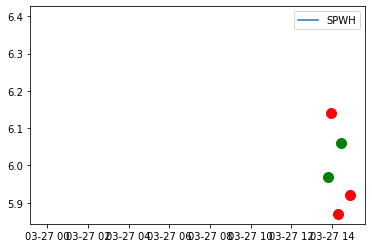

current_value=2.26 series = [1.95   1.9    1.9    1.87   1.87   1.87   1.88   1.88   1.93   1.95
 1.93   1.95   1.9602 1.9    1.91   1.92   1.92   1.9    1.92   1.94
 1.95   1.97   1.99   1.99   1.98   1.96   1.96   1.98   1.97   1.99
 1.97   1.97   1.9799 1.98   1.99   2.02   2.02   2.01   2.     2.02
 2.02   2.01   2.01   2.02   2.04   2.03   2.05   2.05   2.09  ]
[]
{}
resistances=[]
current_value=2.26 series = [1.95   1.9    1.9    1.87   1.87   1.87   1.88   1.88   1.93   1.95
 1.93   1.95   1.9602 1.9    1.91   1.92   1.92   1.9    1.92   1.94
 1.95   1.97   1.99   1.99   1.98   1.96   1.96   1.98   1.97   1.99
 1.97   1.97   1.9799 1.98   1.99   2.02   2.02   2.01   2.     2.02
 2.02   2.01   2.01   2.02   2.04   2.03   2.05   2.05   2.09  ]
[1.87, 1.88, 1.9, 1.92, 1.92, 1.95, 1.9602, 1.98, 1.99, 1.99, 1.99, 2.02, 2.02, 2.02, 2.02, 2.04, 2.05]
{1: [1.87, 1.88], 2: [1.9], 3: [1.92, 1.92], 4: [1.95, 1.9602], 5: [1.98, 1.99, 1.99, 1.99], 6: [2.02, 2.02, 2.02, 2.02, 2.04, 2.05]}
sup

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1141.30,-1141.30,buy,2020-03-27 14:04:27.020902,2.26,"[1.88, 1.92, 1.96, 1.99, 2.03]",[],505,"{'rsi': 67.14756894359668, 'macd': [0.02745061225483969, 0.029299530616472946, 0.0312438452232624, 0.034804275810083496, 0.03719715702984239], 'sell_macd': [0.015289237788286947, 0.01650968741482073, 0.01778653533920016, 0.020108929366779105, 0.021657432123765474], 'slow macd': [0.03196296230623519, 0.03257803431047046, 0.033258149682123594, 0.03431049389301721, 0.03522380938829661], 'macd_signal': [0.03094894258716699, 0.03061906019302818, 0.030744017199075026, 0.03155606892127672, 0.032684286542989854], 'sell_macd_signal': [0.017653077334730722, 0.017424399350748722, 0.01749682654843901, 0.018019247112107027, 0.018746884114438717]}",2.74,2.1
1,-753.22,388.08,sell,2020-03-27 14:20:49.448604,2.31,None,None,168,"{'rsi': 71.61643337571539, 'macd': [0.012980065395669538, 0.013290723778359048, 0.013360188443073628, 0.014799249370863077, 0.01676735854354483], 'reasons': 'scale-out', 'movement': 0.022123893805309856, 'macd_signal': [0.014858100646810177, 0.014544625273119952, 0.014307737907110688, 0.014406040199861166, 0.0148783038685979]}",2.74,2.1
2,-488.90,264.32,sell,2020-03-27 14:33:46.268774,2.36,None,None,112,"{'rsi': 66.9784146359772, 'macd': [0.01767074022370796, 0.018570270856033133, 0.017471589909065166, 0.017334025665855624, 0.018134183065096288], 'reasons': 'bail AND scale-out', 'movement': 0.021645021645021568, 'macd_signal': [0.018388078312617216, 0.018424516821300398, 0.01823393143885335, 0.018053950284253807, 0.018069996840422303]}",2.74,2.1
3,24.10,513.00,sell,2020-03-27 14:47:07.400240,2.28,None,None,225,"{'rsi': 42.56408992576855, 'macd': [0.009393636987041099, 0.005711560022570783, 0.0038175836863270085, 0.0007233477920287612, -0.0016919444345937507], 'reasons': 'below cost & macd negative', 'movement': -0.033855932203389776, 'macd_signal': [0.016048400274338945, 0.013981032223985312, 0.011948342516453651, 0.009703343571568674, 0.007424285970336189]}",2.74,2.1


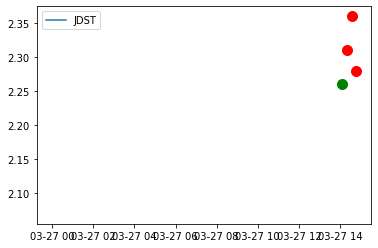

current_value=2.59 series = [2.31   2.3099 2.29   2.28   2.2895 2.31   2.32   2.35   2.4    2.409
 2.4141 2.35   2.36   2.3761 2.3699 2.32   2.3    2.3    2.3    2.3
 2.2998 2.29   2.28   2.28   2.28   2.29   2.28   2.28   2.3    2.29
 2.2998 2.28   2.29   2.29   2.28   2.29   2.28   2.25      nan 2.26
 2.29   2.29   2.3    2.29   2.29   2.29      nan 2.3    2.35   2.33
 2.36   2.35   2.35   2.35   2.35   2.35   2.37   2.39   2.38   2.39
 2.39   2.38   2.38   2.38   2.38  ]
[]
{}
resistances=[]
current_value=2.59 series = [2.31   2.3099 2.29   2.28   2.2895 2.31   2.32   2.35   2.4    2.409
 2.4141 2.35   2.36   2.3761 2.3699 2.32   2.3    2.3    2.3    2.3
 2.2998 2.29   2.28   2.28   2.28   2.29   2.28   2.28   2.3    2.29
 2.2998 2.28   2.29   2.29   2.28   2.29   2.28   2.25      nan 2.26
 2.29   2.29   2.3    2.29   2.29   2.29      nan 2.3    2.35   2.33
 2.36   2.35   2.35   2.35   2.35   2.35   2.37   2.39   2.38   2.39
 2.39   2.38   2.38   2.38   2.38  ]
[2.28, 2.29, 2.29, 2.

<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-844.34,-844.34,buy,2020-03-27 14:03:32.350493,2.59,"[2.29, 2.37]",[],326,"{'rsi': 67.16893779284948, 'macd': [0.026423986653854037, 0.026636307597943, 0.02809454984646953, 0.03127813508566879, 0.03505127867665747], 'sell_macd': [0.015292448693209781, 0.015409296026158703, 0.01633918620733743, 0.018389241073095697, 0.02081280017533471], 'slow macd': [0.022729542507393674, 0.023194904979351172, 0.023905828381213023, 0.024995077255327125, 0.026285113780843083], 'macd_signal': [0.027302539522030395, 0.027169293137212915, 0.02735434447906424, 0.02813910260038515, 0.029521537815639615], 'sell_macd_signal': [0.01605385425511081, 0.01592494260932039, 0.0160077913289238, 0.01648408127775818, 0.017349825057273484]}",3.34,2.35
1,-550.58,293.76,sell,2020-03-27 14:34:09.614918,2.72,None,None,108,"{'rsi': 73.42849062409094, 'macd': [0.01313445620918019, 0.012613525902308353, 0.013342495456663883, 0.01555542633724416, 0.017597250057991953], 'reasons': 'bail AND scale-out', 'movement': 0.02255639097744363, 'macd_signal': [0.015363761663125813, 0.014813714510962321, 0.014519470700102633, 0.014726661827530938, 0.015300779473623141]}",3.34,2.35
2,20.58,571.16,sell,2020-03-27 14:47:07.641816,2.62,None,None,218,"{'rsi': 43.57132058830203, 'macd': [0.009042897702898234, 0.005254719673279062, 0.003268415758338694, 0.0006392384771078952, -0.001158032631346284], 'reasons': 'below cost & macd negative', 'movement': -0.034926470588235364, 'macd_signal': [0.014072411802115674, 0.012308873376348351, 0.01050078185274642, 0.008528473177618715, 0.006591172015825715]}",3.34,2.35


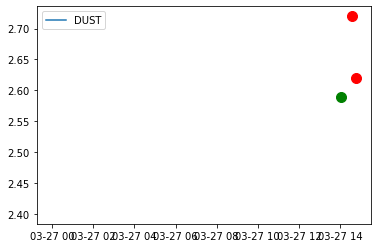

current_value=3.83 series = [3.68   3.69   3.645  3.65   3.63   3.61   3.63   3.625  3.625  3.59
 3.59   3.63   3.6501 3.665  3.6575 3.6659 3.63   3.6    3.59   3.56
 3.56   3.605  3.575  3.585  3.6    3.65   3.67   3.67   3.67   3.67
 3.645  3.625  3.6    3.59   3.56   3.56   3.56   3.58   3.58   3.59
    nan 3.5899    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan 3.59      nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan 3.75
    nan    nan    nan    nan    nan    nan    nan    nan 3.76      nan
    nan 3.82      nan 3.75  ]
[]
{}
resistances=[]
current_value=3.83 series = [3.68   3.69   3.645  3.65   3.63   3.61   3.63   3.625  3.625  3.59
 3.59   3.63   3.6501 3.665  3.6575 3.6659 3.63   3.6    3.59   3.56
 3.56   3.605  3.575  3.585  3.6    3.65   3.67   3.67   3.67   3.67
 3.645  3.625  3.6    3.59   3.56   3.56   3.56   3.58   3.58   3.59
    nan 3.5899    nan    nan    nan    nan    nan    nan   

<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1030.27,-1030.27,buy,2020-03-27 13:49:36.809669,3.83,[3.64],[],269,"{'rsi': 61.77811155034919, 'macd': [0.05115297123001783, 0.053202197753139835, 0.053403703459253826, 0.05454843068245685, 0.05721682459599231], 'sell_macd': [0.03233676732319202, 0.0334614719961821, 0.03338382015700292, 0.03392871716339618, 0.03547112110132078], 'slow macd': [0.01369910281313036, 0.015600813563363403, 0.017165560937226765, 0.018897596708322695, 0.020940709032376326], 'macd_signal': [0.03993416913873796, 0.042587774861618334, 0.04475096058114543, 0.046710454601407714, 0.048811728600324636], 'sell_macd_signal': [0.025731792680281303, 0.027277728543461464, 0.028498946866169755, 0.02958490092561504, 0.030762144960756188]}",4.74,3.54
1,-682.28,347.99,sell,2020-03-27 14:05:53.952014,3.91,None,None,89,"{'rsi': 66.2147384974827, 'macd': [0.02842652252922928, 0.028420080887073595, 0.02778622920634133, 0.026671718426467095, 0.02738935004700105], 'reasons': 'bail AND scale-out', 'movement': 0.020104166666666652, 'macd_signal': [0.03242031601581345, 0.03162026899006548, 0.03085346103332065, 0.03001711251194994, 0.02949156001896016]}",4.74,3.54
2,3.52,685.80,sell,2020-03-27 14:21:10.397472,3.81,None,None,180,"{'rsi': 39.72796045823869, 'macd': [0.01257346708498197, 0.009817745668549538, 0.007023446569140557, 0.0029418700427292777, -0.0005417203680164739], 'reasons': 'below cost & macd negative', 'movement': -0.029919330133769014, 'macd_signal': [0.01609198757780978, 0.014837139195957732, 0.013274400670594298, 0.011207894545021293, 0.00885797156241374]}",4.74,3.54


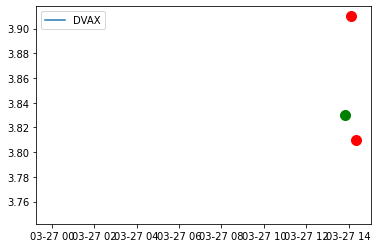

current_value=10.11 series = [8.43   8.4    8.34   8.29   8.29   8.31   8.26   8.25   8.28   8.3
 8.3    8.3202 8.4    8.44   8.45   8.44   8.44   8.39   8.5    8.51
 8.48   8.51   8.54   8.48   8.48   8.5    8.53   8.59   8.56   8.57
 8.54   8.54   8.48   8.42   8.4899 8.48   8.2501 8.25   8.15   8.19
 8.1    8.18  ]
[]
{}
resistances=[]
current_value=10.11 series = [8.43   8.4    8.34   8.29   8.29   8.31   8.26   8.25   8.28   8.3
 8.3    8.3202 8.4    8.44   8.45   8.44   8.44   8.39   8.5    8.51
 8.48   8.51   8.54   8.48   8.48   8.5    8.53   8.59   8.56   8.57
 8.54   8.54   8.48   8.42   8.4899 8.48   8.2501 8.25   8.15   8.19
 8.1    8.18  ]
[8.19, 8.3, 8.31, 8.44, 8.45, 8.4899, 8.51, 8.54, 8.54, 8.57, 8.59]
{1: [8.19], 2: [8.3, 8.31], 3: [8.44, 8.45, 8.4899, 8.51, 8.54, 8.54, 8.57, 8.59]}
supports=[8.3, 8.52]
TLRY analysis for run 121 with profit -14.64


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-727.92,-727.92,buy,2020-03-27 14:02:17.765220,10.11,"[8.3, 8.52]",[],72,"{'rsi': 69.50616300437018, 'macd': [0.27635493039776904, 0.27967009468718906, 0.279072344832036, 0.2853952206454409, 0.30604254248619434], 'sell_macd': [0.15626367832261145, 0.15839342641869258, 0.15799071809851384, 0.16211859839319942, 0.175567354487848], 'slow macd': [0.2496119010568556, 0.2546753061383953, 0.2589248838545348, 0.2644197174368692, 0.27285071831779995], 'macd_signal': [0.3142216282234808, 0.3073113215162225, 0.3016635261793852, 0.2984098650725963, 0.2999364005553159], 'sell_macd_signal': [0.18275695002452, 0.1778842453033545, 0.17390553986238638, 0.171548151568549, 0.1723519921524088]}",13.48,8.99
1,-480.24,247.68,sell,2020-03-27 14:03:47.226826,10.32,None,None,24,"{'rsi': 73.02973929978566, 'macd': [0.15839342641869258, 0.15799071809851384, 0.16211859839319942, 0.17264787396836745, 0.19230902540397388], 'reasons': 'scale-out', 'movement': 0.02051915945611862, 'macd_signal': [0.1778842453033545, 0.17390553986238638, 0.171548151568549, 0.17176809604851268, 0.17587628191960492]}",13.48,8.99
2,-14.64,465.60,sell,2020-03-27 14:31:10.375001,9.70,None,None,48,"{'rsi': 41.51133661767932, 'macd': [0.029400201024433414, 0.027190503121367726, 0.022518134584933236, 0.012091378133362696, -0.002933255181281069], 'reasons': 'below cost & macd negative', 'movement': -0.08646502835538748, 'macd_signal': [0.037655433774747595, 0.03556244764407162, 0.032953585032243944, 0.028781143652467693, 0.02243826388571794]}",13.48,8.99


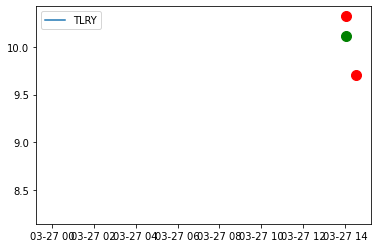

current_value=6.05 series = [5.26   5.32   5.215  5.21   5.22   5.205  5.09   5.08   5.04   5.029
 5.07   5.075  5.05   5.0169 5.01   4.91   4.9288 4.85   4.86   5.
 5.006  5.0199 5.     5.03   5.06   5.07   5.04   5.03   5.05   5.05
 5.06   5.1    5.2    5.2    5.2    5.15   5.2    5.25   5.25   5.2
 5.24   5.15   5.15   5.15   5.13   5.15   5.13   5.18   5.2       nan
    nan 5.19   5.12      nan    nan 5.19   5.12   5.15      nan 5.16
 5.16      nan    nan 5.2    5.2    5.19  ]
[]
{}
resistances=[]
current_value=6.05 series = [5.26   5.32   5.215  5.21   5.22   5.205  5.09   5.08   5.04   5.029
 5.07   5.075  5.05   5.0169 5.01   4.91   4.9288 4.85   4.86   5.
 5.006  5.0199 5.     5.03   5.06   5.07   5.04   5.03   5.05   5.05
 5.06   5.1    5.2    5.2    5.2    5.15   5.2    5.25   5.25   5.2
 5.24   5.15   5.15   5.15   5.13   5.15   5.13   5.18   5.2       nan
    nan 5.19   5.12      nan    nan 5.19   5.12   5.15      nan 5.16
 5.16      nan    nan 5.2    5.2    5.19  ]
[4.9288

<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-750.20,-750.20,buy,2020-03-27 14:01:03.425186,6.05,"[5.05, 5.2]",[],124,"{'rsi': 69.24154046947353, 'macd': [0.12597942915780358, 0.12483965597781932, 0.12485334187979369, 0.13070847081290982, 0.1474313385432664], 'sell_macd': [0.07271211530171051, 0.07184446256881483, 0.0717522076786512, 0.07548094143074913, 0.08627890355665979], 'slow macd': [0.0870274222871803, 0.08946329201898262, 0.09202829925001144, 0.09569801873885364, 0.10165292976199325], 'macd_signal': [0.14078943710936218, 0.1375994808830536, 0.13505025308240162, 0.13418189662850327, 0.1368317850114559], 'sell_macd_signal': [0.08371671462718926, 0.08134226421551437, 0.07942425290814173, 0.0786355906126632, 0.08016425320146252]}",8.0,5.4
1,-496.82,253.38,sell,2020-03-27 14:15:09.507074,6.18,None,None,41,"{'rsi': 66.01448546383733, 'macd': [0.06609435265137442, 0.06591234408190516, 0.0645508783903459, 0.06600232228795733, 0.07160081984079802], 'reasons': 'scale-out', 'movement': 0.021487603305785107, 'macd_signal': [0.07398285822929854, 0.07236875539981986, 0.07080517999792507, 0.06984460845593152, 0.07019585073290482]}",8.0,5.4
2,-28.70,468.12,sell,2020-03-27 14:20:07.366496,5.64,None,None,83,"{'rsi': 39.35489104570482, 'macd': [0.06083183038372031, 0.053803944194137365, 0.0331873582776554, 0.014249923040427603, -0.0006915839371588461], 'reasons': 'below cost & macd negative', 'movement': -0.08737864077669903, 'macd_signal': [0.06797147998827162, 0.06513797282944477, 0.058747849919086895, 0.04984826454335504, 0.039740294847252264]}",8.0,5.4


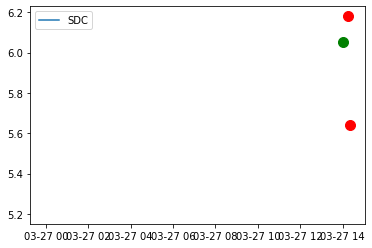

current_value=17.35 series = [15.51 15.45 15.45 15.49 15.46 15.42 15.42 15.43 15.44 15.43 15.45 15.45
 15.41 15.4  15.39 15.39 15.37 15.3  15.37 15.42 15.49 15.44 15.48 15.5
 15.42 15.43 15.43 15.52 15.55 15.6  15.63 15.62 15.58 15.46 15.44 15.42
 15.46 15.48 15.35 15.36 15.39 15.25]
[]
{}
resistances=[]
current_value=17.35 series = [15.51 15.45 15.45 15.49 15.46 15.42 15.42 15.43 15.44 15.43 15.45 15.45
 15.41 15.4  15.39 15.39 15.37 15.3  15.37 15.42 15.49 15.44 15.48 15.5
 15.42 15.43 15.43 15.52 15.55 15.6  15.63 15.62 15.58 15.46 15.44 15.42
 15.46 15.48 15.35 15.36 15.39 15.25]
[15.39, 15.39, 15.43, 15.44, 15.45, 15.45, 15.48, 15.49, 15.49, 15.5, 15.63]
{1: [15.39, 15.39, 15.43, 15.44, 15.45, 15.45, 15.48, 15.49, 15.49, 15.5, 15.63]}
supports=[15.47]
SPXS analysis for run 121 with profit -60.5


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1908.5,-1908.5,buy,2020-03-27 13:48:06.966672,17.35,[15.47],[],110,"{'rsi': 69.26515320939927, 'macd': [0.2785044863581305, 0.2782431370023808, 0.278265804749271, 0.28427027885581424, 0.28733851037683067], 'sell_macd': [0.1765385666983832, 0.1751837567653105, 0.1740659340023285, 0.17689794309607976, 0.17785148338866108], 'slow macd': [0.06955229549542352, 0.07774759899155725, 0.08584452140204846, 0.09499271827566957, 0.10357889585787916], 'macd_signal': [0.21817948898098072, 0.23019221858526073, 0.23980693581806278, 0.24869960442561306, 0.2564273856158566], 'sell_macd_signal': [0.1413292860420246, 0.14810018018668178, 0.15329333094981112, 0.15801425337906486, 0.1619816993809841]}",19.54,16.62
1,-60.5,1848.0,sell,2020-03-27 14:09:02.268569,16.80,None,None,110,"{'rsi': 39.0025456051085, 'macd': [0.027216867895749175, 0.019763570958943433, 0.01571991658014582, 0.009247979186536526, -0.0005905172135065584], 'reasons': 'below cost & macd negative', 'movement': -0.031700288184438076, 'macd_signal': [0.0507092132181916, 0.044520084766341964, 0.03876005112910273, 0.03285763674058949, 0.026168005949770277]}",19.54,16.62


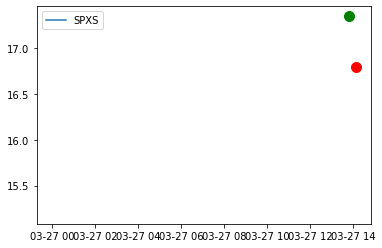

current_value=8.69 series = [8.06   8.01   8.     7.9599 7.97   7.96   8.02   7.98   8.01   8.06
 8.14   8.09   8.04   8.01   8.06   8.14   8.12   8.05   8.05   8.06
 8.15   8.22   8.24   8.3    8.3    8.35   8.37   8.31   8.33   8.2929
 8.3    8.2    8.16   8.21   8.23   8.2    8.18   8.12   8.11   8.14
 8.14   8.15   8.11   8.17   8.19   8.2201 8.23   8.18   8.2    8.09
 8.11   8.2    8.26   7.93   7.9       nan    nan    nan    nan 8.15
    nan    nan    nan    nan    nan 8.15      nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan 8.    ]
[]
{}
resistances=[]
current_value=8.69 series = [8.06   8.01   8.     7.9599 7.97   7.96   8.02   7.98   8.01   8.06
 8.14   8.09   8.04   8.01   8.06   8.14   8.12   8.05   8.05   8.06
 8.15   8.22   8.24   8.3    8.3    8.35   8.37   8.31   8.33   8.2929
 8.3    8.2    8.16   8.21   8.23   8.2    8.18   8.12   8.11   8.14


<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2094.29,-2094.29,buy,2020-03-27 13:48:10.653976,8.69,"[7.99, 8.23]",[],241,"{'rsi': 64.27334575652867, 'macd': [0.12809426011288672, 0.1252299264940433, 0.12321792805769682, 0.12495191300861741, 0.12688079679627862], 'sell_macd': [0.08061770026834658, 0.0782498567348231, 0.07646907142643045, 0.07715847155721, 0.07799230969084192], 'slow macd': [0.04113620674728935, 0.04413122019193594, 0.04714881357672951, 0.050794909987804004, 0.05446803601816619], 'macd_signal': [0.10156125936685814, 0.10629499279229518, 0.1096795798453755, 0.11273404647802389, 0.11556339654167483], 'sell_macd_signal': [0.06503943825447736, 0.06768152195054651, 0.0694390318457233, 0.07098291978802064, 0.07238479776858489]}",9.71,8.37
1,-45.79,2048.50,sell,2020-03-27 15:07:50.987471,8.50,None,None,241,"{'rsi': 35.630330677860265, 'macd': [0.010834595119387558, 0.008687310075846, 0.004802577443530964, 0.0012144406203837832, -0.004142736652463341], 'reasons': 'below cost & macd negative', 'movement': -0.023434807581849584, 'macd_signal': [0.012651294793957563, 0.011858497850335251, 0.010447313768974394, 0.008600739139256273, 0.00605204398091235]}",9.71,8.37


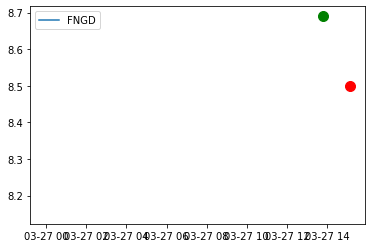

current_value=14.22 series = [12.9099 12.87   12.93   13.0299 13.0899 13.13   13.059  13.08   13.1
 13.1    13.07   13.1214 12.8294 12.74   12.9213 12.94   12.85   12.88
 12.9099 12.9    12.84   12.821  12.845  12.772  12.8    12.785  12.79
 12.75   12.552  12.6    12.45   12.4399 12.11   12.6    12.4    12.3
     nan     nan     nan     nan 12.3004     nan 12.4    12.39   12.28
 12.39       nan 12.39       nan     nan     nan     nan 12.39   12.12
 12.39   12.38       nan 12.4        nan 12.54   12.54       nan 12.53
 12.65       nan 12.65   12.65   12.65       nan 12.6        nan 12.61
 12.65       nan 12.68   12.68   12.65   12.68   12.68   12.73  ]
[]
{}
resistances=[]
current_value=14.22 series = [12.9099 12.87   12.93   13.0299 13.0899 13.13   13.059  13.08   13.1
 13.1    13.07   13.1214 12.8294 12.74   12.9213 12.94   12.85   12.88
 12.9099 12.9    12.84   12.821  12.845  12.772  12.8    12.785  12.79
 12.75   12.552  12.6    12.45   12.4399 12.11   12.6    12.4    12.3
     na

<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2545.38,-2545.38,buy,2020-03-27 14:28:18.867092,14.22,"[12.75, 13.11]",[],179,"{'rsi': 66.86322445199443, 'macd': [0.04318599219253727, 0.047472251531768705, 0.05776408148094703, 0.06396464247838374, 0.07448343365895838], 'sell_macd': [0.022627627016033713, 0.025638574120643298, 0.03251933064214896, 0.03667421454666986, 0.04359653688075582], 'slow macd': [0.12082376239975368, 0.1201757988522072, 0.12088604782529266, 0.12110465586038721, 0.1223931798369211], 'macd_signal': [0.02994753976789482, 0.0334524821206696, 0.038314801992725085, 0.04344477008985682, 0.049652502803677126], 'sell_macd_signal': [0.012367587423709744, 0.015021784763096454, 0.018521293938906953, 0.022151878060459533, 0.02644080982451879]}",15.58,13.78
1,-3.58,2541.80,sell,2020-03-27 14:59:10.967766,14.20,None,None,179,"{'rsi': 43.41912744454207, 'macd': [0.016820445007219575, 0.011805653222257462, 0.00906418360771255, 0.003932334770302859, -0.0011045907493709706], 'reasons': 'below cost & macd negative', 'movement': -0.002037947997189031, 'macd_signal': [0.023194039994868947, 0.02091636264034665, 0.01854592683381983, 0.015623208421116436, 0.012277648587018955]}",15.58,13.78


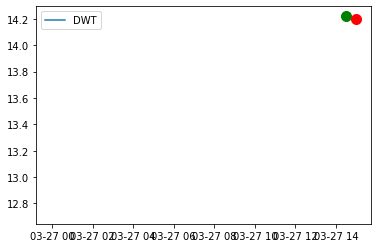

current_value=7.03 series = [6.29      nan 6.29      nan 6.2935 6.2927    nan 6.32   6.34      nan
    nan 6.33   6.33      nan    nan    nan 6.395  6.42   6.4027    nan
 6.44      nan    nan    nan 6.52      nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan

<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1609.87,-1609.87,buy,2020-03-27 14:00:03.084949,7.03,"[6.42, 6.58, 6.95]",[],229,"{'rsi': 64.25547802548714, 'macd': [0.16025975191268937, 0.15987007495794447, 0.15694517050669976, 0.1592467961302919, 0.16162844815868738], 'sell_macd': [0.10109786771611429, 0.10012315831311636, 0.09754386321580455, 0.0984230636176946, 0.09938837479296314], 'slow macd': [0.013404491747295744, 0.0188379848859066, 0.023646907625771263, 0.02931293865093121, 0.034958794562282236], 'macd_signal': [0.14353924698142012, 0.146805412576725, 0.14883336416271994, 0.15091605055623433, 0.15305853007672493], 'sell_macd_signal': [0.09358239092641203, 0.0948905444037529, 0.09542120816616323, 0.09602157925646951, 0.09669493836376823]}",8.08,6.68
1,-112.21,1497.66,sell,2020-03-27 14:05:28.090326,6.54,None,None,229,"{'rsi': 41.393207159137305, 'macd': [0.08677955042027907, 0.07781181073219212, 0.06825497706962835, 0.05888270438360976, 0.036794145090820685], 'reasons': 'stopped', 'movement': -0.06968705547652922, 'macd_signal': [0.0947492152661314, 0.09136173435934355, 0.08674038290140051, 0.08116884719784237, 0.07229390677643803]}",8.08,6.68


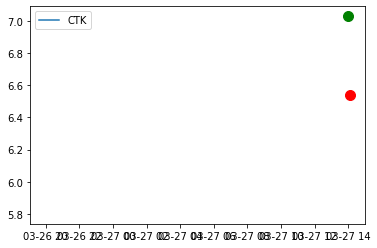

current_value=4.65 series = [0.297    0.2989   0.2945   0.2991   0.2923   0.299    0.301201 0.2991
      nan 0.2991        nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan 0.2803        nan      nan      nan
      nan 0.2803        nan 0.2803        nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      n

<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-325.5,-325.5,buy,2020-03-27 14:39:21.663467,4.65,"[0.28, 0.29, 0.3]",[],70,"{'rsi': 70.67293290630012, 'macd': [0.3370716640260758, 0.32935089273575535, 0.3267280560526187, 0.32812124034870704, 0.3302677951066251], 'sell_macd': [0.19078179065288392, 0.18600875218536927, 0.1845491280264575, 0.18568514649968826, 0.1872809382125995], 'slow macd': [0.4669598952549596, 0.46614688050973374, 0.4660927683742666, 0.4667353580994935, 0.46754129873338], 'macd_signal': [0.3124418322716493, 0.3158236443644705, 0.31800452670210017, 0.32002786943142153, 0.32207585456646226], 'sell_macd_signal': [0.17233975560002152, 0.17507355491709106, 0.17696866953896434, 0.17871196493110914, 0.1804257595874072]}",8.1,3.5
1,-43.4,282.1,sell,2020-03-27 14:55:49.393465,4.03,None,None,70,"{'rsi': 46.14168746368827, 'macd': [0.03066543313178638, 0.029136962957062806, 0.017177934730562505, 0.008155601895230014, -0.002617067871200085], 'reasons': 'below cost & macd negative', 'movement': -0.151578947368421, 'macd_signal': [0.09057044583339455, 0.0782837492581282, 0.06606258635261505, 0.054481189461138044, 0.04306153799467042]}",8.1,3.5


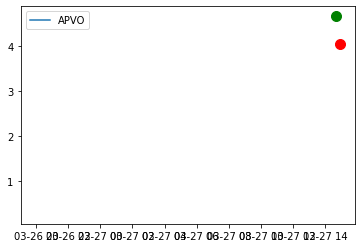

current_value=6.89 series = [6.13   6.135  6.13   6.19   6.205  6.2    6.21   6.24   6.21   6.225
 6.24   6.23      nan 6.2    6.11   6.     5.9208 5.91      nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan 

<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1612.26,-1612.26,buy,2020-03-27 14:55:45.729596,6.89,"[6.3, 6.61]",[],234,"{'rsi': 66.91260023262706, 'macd': [0.0762634646159217, 0.07790799194473053, 0.0759154365249115, 0.07668006761736201, 0.08159047582236045], 'sell_macd': [0.04530929692640839, 0.04625776772620949, 0.04483764409324653, 0.04522666926115537, 0.04831906979119971], 'slow macd': [0.04501578910632009, 0.047062676063826636, 0.048390799288523745, 0.050175064919420365, 0.05277598253518079], 'macd_signal': [0.0685783590611972, 0.07044428563790386, 0.07153851581530539, 0.07256682617571672, 0.07437155610504546], 'sell_macd_signal': [0.040902731944996024, 0.041973739101238715, 0.04254652009964028, 0.0430825499319433, 0.04412985390379458]}",7.94,6.56
1,-9.36,1602.90,sell,2020-03-27 16:48:08.361679,6.85,None,None,234,"{'rsi': 44.97815314500449, 'macd': [0.011365919338175878, 0.007914843191522358, 0.0035644612176168877, 0.0022061835597995128, -0.001478268947068706], 'reasons': 'below cost & macd negative', 'movement': -0.03107344632768358, 'macd_signal': [0.021289727591829635, 0.01861475071176818, 0.01560469281293792, 0.01292499096231024, 0.01004433898043445]}",7.94,6.56


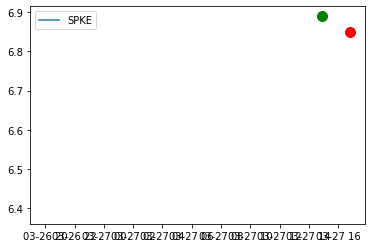

current_value=6.11 series = [5.9    5.95   5.97   5.88   5.8919 5.8097 5.8401 5.78   5.786  5.865
 5.851  5.8076 5.7707 5.755  5.74   5.7399 5.744  5.7264 5.73   5.7498
 5.74   5.8    5.847  5.7703 5.74   5.7074 5.69   5.759  5.8    5.5093
 5.4397 5.41   5.5    5.6    5.6    5.59      nan 5.5    5.65   5.49
 5.55   5.55   5.51      nan 5.51      nan 5.51   5.51   5.55      nan
    nan 5.52   5.51      nan    nan    nan    nan 5.53   5.53   5.55
    nan    nan 5.63      nan 5.52   5.62   5.62   5.59   5.61   5.61
 5.6       nan 5.61      nan 5.61   5.6       nan 5.61   5.61  ]
[]
{}
resistances=[]
current_value=6.11 series = [5.9    5.95   5.97   5.88   5.8919 5.8097 5.8401 5.78   5.786  5.865
 5.851  5.8076 5.7707 5.755  5.74   5.7399 5.744  5.7264 5.73   5.7498
 5.74   5.8    5.847  5.7703 5.74   5.7074 5.69   5.759  5.8    5.5093
 5.4397 5.41   5.5    5.6    5.6    5.59      nan 5.5    5.65   5.49
 5.55   5.55   5.51      nan 5.51      nan 5.51   5.51   5.55      nan
    nan 5.52   5

<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1661.92,-1661.92,buy,2020-03-27 13:47:32.131913,6.11,"[5.6, 5.82]",[],272,"{'rsi': 67.53006764309983, 'macd': [0.09658234966106516, 0.09950414756197024, 0.09986961147222928, 0.10180187394924456, 0.10494764228366726], 'sell_macd': [0.06240505994337475, 0.06384789832683513, 0.06362870877723559, 0.06444455187135034, 0.06606151334895394], 'slow macd': [0.016154246118080806, 0.01973747384075608, 0.02284425396651102, 0.026224231596856384, 0.029851753228618882], 'macd_signal': [0.06272906958731934, 0.07008408518224953, 0.07604119044024547, 0.08119332714204529, 0.08594419017036968], 'sell_macd_signal': [0.041628952743150135, 0.046072741859887134, 0.04958393524335682, 0.052556058568955524, 0.05525714952495521]}",7.0,5.81
1,-51.68,1610.24,sell,2020-03-27 14:07:32.265819,5.92,None,None,272,"{'rsi': 44.81572032700625, 'macd': [0.008867831133266613, 0.007597375213064694, 0.0036515994932573292, 0.0010594158220662564, -0.000465135296031427], 'reasons': 'below cost & macd negative', 'movement': -0.027823240589198023, 'macd_signal': [0.021229182779471212, 0.01850282126618991, 0.015532576911603393, 0.012637944693695965, 0.010017328695750487]}",7.0,5.81


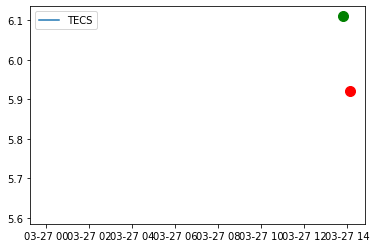

current_value=7.1 series = [6.71   6.73   6.66   6.635  6.6    6.61   6.62   6.65   6.65   6.65
 6.655  6.655  6.648  6.64   6.64   6.63   6.63   6.59   6.55   6.47
 6.47   6.48   6.45   6.47   6.46   6.49   6.5    6.51   6.52   6.62
 6.59   6.61   6.64   6.6303 6.64   6.64   6.67   6.66   6.64   6.645
 6.625  6.645  6.64   6.68   6.69   6.7    6.695  6.76   6.71  ]
[]
{}
resistances=[]
current_value=7.1 series = [6.71   6.73   6.66   6.635  6.6    6.61   6.62   6.65   6.65   6.65
 6.655  6.655  6.648  6.64   6.64   6.63   6.63   6.59   6.55   6.47
 6.47   6.48   6.45   6.47   6.46   6.49   6.5    6.51   6.52   6.62
 6.59   6.61   6.64   6.6303 6.64   6.64   6.67   6.66   6.64   6.645
 6.625  6.645  6.64   6.68   6.69   6.7    6.695  6.76   6.71  ]
[6.47, 6.48, 6.62, 6.63, 6.64, 6.64, 6.64, 6.645, 6.645, 6.65, 6.65, 6.655, 6.655, 6.67, 6.7, 6.73, 6.76]
{1: [6.47, 6.48], 2: [6.62, 6.63, 6.64, 6.64, 6.64, 6.645, 6.645, 6.65, 6.65, 6.655, 6.655, 6.67, 6.7, 6.73, 6.76]}
supports=[6.48, 6.6

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1611.70,-1611.70,buy,2020-03-27 13:53:19.411137,7.10,"[6.48, 6.66]",[],227,"{'rsi': 72.93941893919708, 'macd': [0.07080566672150024, 0.08045681742693844, 0.08670251308018084, 0.09060780154833115, 0.09303379335046191], 'sell_macd': [0.043872227047063284, 0.04994123653711213, 0.053762007093811626, 0.056041023019891334, 0.0573488143516423], 'slow macd': [0.03696802320120174, 0.04051541571330919, 0.04363436353718164, 0.04643410823473548, 0.04901566605805918], 'macd_signal': [0.05447298088258782, 0.05966974819145794, 0.06507630116920252, 0.07018260124502824, 0.07475283966611498], 'sell_macd_signal': [0.03381039018083508, 0.03703655945209049, 0.04038164898043471, 0.043513523788326035, 0.046280581900989284]}",8.17,6.74
1,-9.08,1602.62,sell,2020-03-27 14:40:20.122967,7.06,None,None,227,"{'rsi': 42.97329347932716, 'macd': [0.014767064380199812, 0.010940662419219649, 0.007297483457167964, 0.002805428636644791, -0.0003676715954084031], 'reasons': 'below cost & macd negative', 'movement': -0.003239436619718266, 'macd_signal': [0.022009399109140747, 0.01979565177115653, 0.017296018108358815, 0.01439790021401601, 0.011444785852131127]}",8.17,6.74


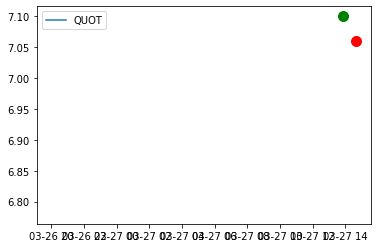

current_value=15.09 series = [13.93   13.91   14.2799 14.2323 14.4394 14.44   14.65   14.7632 14.57
 14.51   14.3579 14.51   14.37   14.45   14.59   14.62   14.4981 14.62
 14.33   14.3224 14.3096 14.2808 14.225  14.14   14.2599 14.26   14.2234
 14.19   14.135  14.285  14.16   14.3    14.53   14.6699 14.24   14.0101
 14.12   14.05   14.11   14.13   14.13   14.13       nan     nan     nan
 14.13       nan     nan     nan 14.11   14.08       nan     nan     nan
     nan 14.08   14.08       nan     nan     nan     nan     nan 14.09
     nan 14.0799     nan     nan 14.07   14.08       nan     nan 14.14
     nan 14.14       nan     nan 14.11       nan     nan 14.14  ]
[]
{}
resistances=[]
current_value=15.09 series = [13.93   13.91   14.2799 14.2323 14.4394 14.44   14.65   14.7632 14.57
 14.51   14.3579 14.51   14.37   14.45   14.59   14.62   14.4981 14.62
 14.33   14.3224 14.3096 14.2808 14.225  14.14   14.2599 14.26   14.2234
 14.19   14.135  14.285  14.16   14.3    14.53   14.6699 14.24  

<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-162-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1795.71,-1795.71,buy,2020-03-27 14:34:24.040185,15.09,"[14.2, 14.64]",[],119,"{'rsi': 63.95559940613883, 'macd': [0.06985945412037786, 0.06542627383756461, 0.06790824058080247, 0.06907891833598079, 0.07718609984404345], 'sell_macd': [0.0420809219580498, 0.039026654278149664, 0.04050350213435472, 0.04112827316341772, 0.04627577950861905], 'slow macd': [0.057865577744786734, 0.058050566296079964, 0.05947138052692402, 0.06068345890479776, 0.06330091532697679], 'macd_signal': [0.06832770757416054, 0.06774742082684135, 0.06777958477763357, 0.06803945148930302, 0.06986878116025111], 'sell_macd_signal': [0.04184430508238032, 0.04128077492153419, 0.04112532036409829, 0.04112591092396218, 0.04215588464089355]}",17.12,14.43
1,-27.37,1768.34,sell,2020-03-27 14:54:10.818449,14.86,None,None,119,"{'rsi': 42.99019153108107, 'macd': [0.01768331353549968, 0.014681560390597426, 0.011112901311575385, 0.0024735188953037834, -0.004290591025107204], 'reasons': 'below cost & macd negative', 'movement': -0.01589403973509935, 'macd_signal': [0.024774213201608185, 0.022755682639406034, 0.020427126373839904, 0.01683640487813268, 0.012611005697484703]}",17.12,14.43


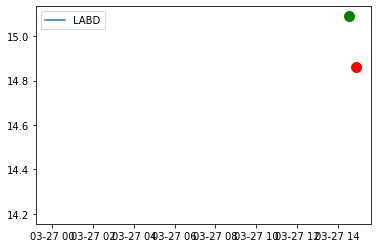

In [163]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d").date()
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])

